In [74]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [75]:
# import data using pandas
import pandas as pd

df = pd.read_csv('../../Annabel_data/FINAL_cleaning_data.csv')
df.head()

,Time,Replicates,Surface,Cleaning,Count
0,-48.0,1,Stainless Steel,NIL,6016.0
1,-48.0,2,Stainless Steel,NIL,5767.0
2,-48.0,3,Stainless Steel,NIL,5500.0
3,-48.0,4,Stainless Steel,NIL,6700.0
4,-41.0,1,Stainless Steel,NIL,1075.0


## Plot logistic growth of NIL data



KYDEX: [-2.05350362e-01  1.26083510e+10]
Stainless Steel: [-2.35104701e-01  2.59015108e+09]


/var/folders/nj/1xvlt_gx5cnbgn9v19jkqlzc0000gn/T/ipykernel_4945/2711218350.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_before_cleaning['Count'].iloc[i] = np.random.normal(data_before_cleaning['Count'].iloc[i - 1], 200)
/var/folders/nj/1xvlt_gx5cnbgn9v19jkqlzc0000gn/T/ipykernel_4945/2711218350.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_before_cleaning['Count'].iloc[i] = np.random.normal(data_before_cleaning['Count'].iloc[i - 1], 200)
/var/folders/nj/1xvlt_gx5cnbgn9v19jkqlzc0000gn/T/ipykernel_4945/2711218350.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

KeyError: 'std'

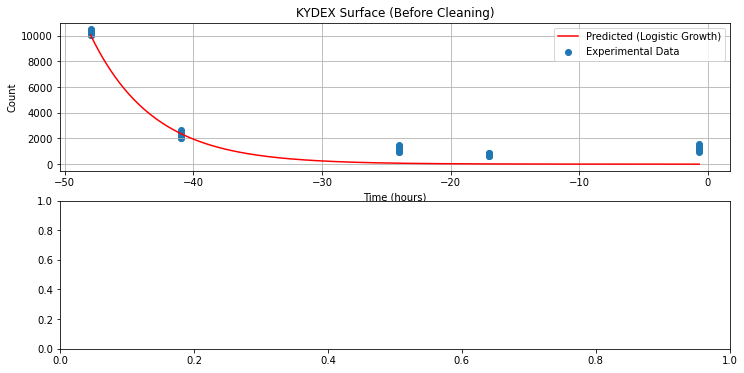

In [124]:
# Define the logistic growth model
def logistic_growth_model(y, t, r, K):
    C = y
    dCdt = r * C * (1 - C / K)
    return dCdt

# Function to predict using the logistic growth model
def predict_logistic_growth(t, r, K, C0):
    solution = odeint(logistic_growth_model, C0, t, args=(r, K))
    return solution.ravel()

# Function to fit the logistic growth model to the data
def fit_logistic_growth(subgroup_data):
    # Define the function to fit the data
    def fit_func(t, r, K):
        y0 = subgroup_data['Count'].iloc[0]
        solution = odeint(logistic_growth_model, y0, t, args=(r, K))
        return solution.ravel()

    # Extract time and count data
    t_data = subgroup_data['Time'].values
    count_data = subgroup_data['Count'].values

    # Provide initial guesses for the parameters
    initial_guesses = (0.1, max(count_data))

    # Fit the ODE to the data using curve_fit
    popt, _ = curve_fit(fit_func, t_data, count_data, p0=initial_guesses)
    return popt

# data_before_cleaning: data before cleaning from df, only NIL data
data_before_cleaning = df[df['Cleaning'] == 'NIL']


# Replace NAN values with the mean of the data at that time point. Add Gaussian noise to the at that time point only.
for i in range(len(data_before_cleaning)):
    if np.isnan(data_before_cleaning['Count'].iloc[i]):
        data_before_cleaning['Count'].iloc[i] = np.random.normal(data_before_cleaning['Count'].iloc[i - 1], 200)

# Get the NIL data for each surface type
nil_data_kydex = data_before_cleaning[(data_before_cleaning['Surface'] == 'KYDEX') & (data_before_cleaning['Cleaning'] == 'NIL')]
nil_data_stainless_steel = data_before_cleaning[(data_before_cleaning['Surface'] == 'Stainless Steel') & (data_before_cleaning['Cleaning'] == 'NIL')]

# Fit the logistic growth model to the NIL data for each surface type
parameters_kydex = fit_logistic_growth(nil_data_kydex)
parameters_stainless_steel = fit_logistic_growth(nil_data_stainless_steel)

# Parameters for KYDEX and Stainless Steel surfaces
parameters_kydex, parameters_stainless_steel

print('KYDEX:',parameters_kydex)

print('Stainless Steel:',parameters_stainless_steel)

# Time points for prediction
t_pred = np.linspace(nil_data_kydex['Time'].min(), nil_data_kydex['Time'].max(), 300)

# Predicted counts for KYDEX using logistic growth model
predicted_counts_kydex = predict_logistic_growth(t_pred, *parameters_kydex, nil_data_kydex['Count'].iloc[0])

# Predicted counts for Stainless Steel using logistic growth model
predicted_counts_stainless_steel = predict_logistic_growth(t_pred, *parameters_stainless_steel, nil_data_stainless_steel['Count'].iloc[0])

# Plot the experimental vs. predicted data for KYDEX
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.scatter(nil_data_kydex['Time'], nil_data_kydex['Count'], label='Experimental Data')
plt.plot(t_pred, predicted_counts_kydex, color='red', label='Predicted (Logistic Growth)')
plt.xlabel('Time (hours)')
plt.ylabel('Count')
plt.title('KYDEX Surface (Before Cleaning)')
plt.legend()
plt.grid(True)

# Plot the experimental vs. predicted data for Stainless Steel
plt.subplot(2, 1, 2)
#plot errorbars of nil_data_stainless_steel for each time point. Calculate the mean and std of each time point first
data=nil_data_stainless_steel.groupby('Time').agg({'Count': ['mean', 'std']}).reset_index().plot(x='Time', y='Count', yerr='std', kind='scatter', ax=plt.gca(), label='Experimental Data', alpha=.4)

#plot the predicted data
plt.errorbar(data['Time'], data['mean'], yerr=data['std'], fmt='o', color='red', label='Predicted (Logistic Growth)')

#plt.scatter(nil_data_stainless_steel['Time'], nil_data_stainless_steel['Count'], label='Experimental Data',alpha=.4)
plt.plot(t_pred, predicted_counts_stainless_steel, color='red', label='Predicted (Logistic Growth)')
plt.xlabel('Time (hours)')
plt.ylabel('Count')
plt.title('Stainless Steel Surface (Before Cleaning)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



---

### Bayesian Inference for Bacterial Growth Modeling

#### Introduction

The aim of this analysis is to model the bacterial growth dynamics under various cleaning methods and surface types. The dataset includes observations of bacterial counts at different time intervals, cleaning methods, and surface materials. Our objective is to fit an appropriate mathematical model to this data, infer the underlying parameters, and make predictions.

#### Model Description

The Ordinary Differential Equation (ODE) model chosen to describe the bacterial growth dynamics is given by:


$$\frac{{dC}}{{dt}} = r \cdot C \cdot \left(1 - \frac{{C}}{{K}}\right) - m \cdot \exp(-g \cdot t) \cdot C$$

where:
- \( C \): Bacterial count
- \( r \): Intrinsic growth rate
- \( K \): Carrying capacity
- \( m \): Cleaning effect magnitude
- \( g \): Cleaning effect decay rate
- \( t \): Time

This model combines the logistic growth function with an exponential decay term representing the effect of cleaning.

#### Analysis Steps

1. **Data Preprocessing**: Filtering and transforming data to include positive time intervals and specific cleaning methods.
2. **Model Calibration**: Fitting the ODE model to the data using both frequentist (curve fitting) and Bayesian inference approaches.
3. **Incorporation of Control Data**: Utilizing control (NIL + CON) data to infer the intrinsic growth rate \( r \) and carrying capacity \( K \).
4. **Predictions**: Using the inferred parameters to make predictions of bacterial counts for different cleaning methods and surface types.
5. **Comparison with Alternative Models**: Exploring alternative growth models (e.g., Gompertz, Richards) and comparing their fits.
6. **Bayesian Inference**: Implementing a Bayesian approach to estimate the posterior distributions of the model parameters, considering likelihood functions, priors, and Markov Chain Monte Carlo (MCMC) sampling.
7. **Visualizations**: Plotting the experimental vs. predicted bacterial counts, and visualizing the posterior distributions of parameters.

#### Conclusion

This comprehensive analysis leverages mathematical modeling and statistical inference to understand and predict bacterial growth dynamics under different conditions. The results provide valuable insights into the effectiveness of various cleaning methods and contribute to informed decision-making in hygiene management.


In [12]:
import pymc3 as pm
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [4]:
# import data
df = pd.read_csv('../../Annabel_data/FINAL_cleaning_data.csv')
df.head()

,Time,Replicates,Surface,Cleaning,Count
0,-48.0,1,Stainless Steel,NIL,6016.0
1,-48.0,2,Stainless Steel,NIL,5767.0
2,-48.0,3,Stainless Steel,NIL,5500.0
3,-48.0,4,Stainless Steel,NIL,6700.0
4,-41.0,1,Stainless Steel,NIL,1075.0


In [5]:
# filter df to incldue only Cleaining = NIL and surface == KYDEX
control_data = df[(df['Cleaning'] == 'DW') & (df['Surface'] == 'KYDEX') & (df['Time'] > -.5)]
#average the Count values for each time point
control_data = control_data.groupby('Time')['Count'].agg(['mean', 'std']).reset_index()
print(control_data.head())


   Time        mean         std
0   0.0  960.500000  156.469486
1   1.0  683.500000  109.260697
2   2.0  750.166667   54.027462
3   4.0  888.833333   67.603008


In [71]:
df[(df['Surface'] == surface) & (df['Cleaning'] == cleaning) & (df['Time'] > -.5)]['Count'].std()

181.7706340578618

In [166]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import pymc3 as pm
import theano.tensor as tt

# Select specific surface and cleaning method
surface = 'KYDEX'
cleaning = 'DW'
subgroup_data = df[(df['Surface'] == surface) & (df['Cleaning'] == cleaning) & (df['Time'] > -.5)]

# Group by time and calculate the mean
grouped_data = subgroup_data.groupby('Time').agg({'Count': ['mean', 'std']}).reset_index()
grouped_data.columns = ['Time', 'mean', 'std']

# Logistic decay model function
def logistic_decay_model(C, t, r, K, m, g):
    dCdt = r * C * (1 - C / K) - m * tt.exp(-g * t) * C
    return dCdt

# PyMC3 model
with pm.Model() as model:
    # Priors
    '''
    r = pm.Normal('r', 0.5, 0.1)
    K = pm.Normal('K', 1.5, 0.1)
    m = pm.Normal('m', 0.5, 0.1)
    g = pm.Normal('g', 0.5, 0.1)
    '''
    r = pm.Uniform('r', lower=0.001, upper=2)
    K = pm.Uniform('K', lower=100, upper=2000)  
    m = pm.Uniform('m', lower=0.001, upper=2)
    g = pm.Uniform('g', lower=0.001, upper=2)
    
    sigma = pm.HalfNormal('sigma', 0.1)
    
    # Initial condition
    C0 = grouped_data['mean'].iloc[0]

    # Time intervals
    time_intervals = np.diff(grouped_data['Time'])
    time_intervals = np.insert(time_intervals, 0, grouped_data['Time'].iloc[0])

    # Solve ODE using scan
    sequences = [time_intervals]
    outputs_info = [C0]
    non_sequences = [r, K, m, g]
    
    expected_counts, _ = theano.scan(fn=logistic_decay_model,
                                     sequences=sequences,
                                     outputs_info=outputs_info,
                                     non_sequences=non_sequences)
    
    # Cumulative sum to get counts at each time point
    expected_counts = C0 + tt.extra_ops.cumsum(expected_counts)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=expected_counts, sigma=sigma, observed=grouped_data['mean'])

    # Sample
    trace = pm.sample(1000, tune=1000)

# Summary of the results
summary = pm.summary(trace)
print(summary)


NameError: name 'theano' is not defined

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'K'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'sigma'}>, <AxesSubplot:>]],
      dtype=object)

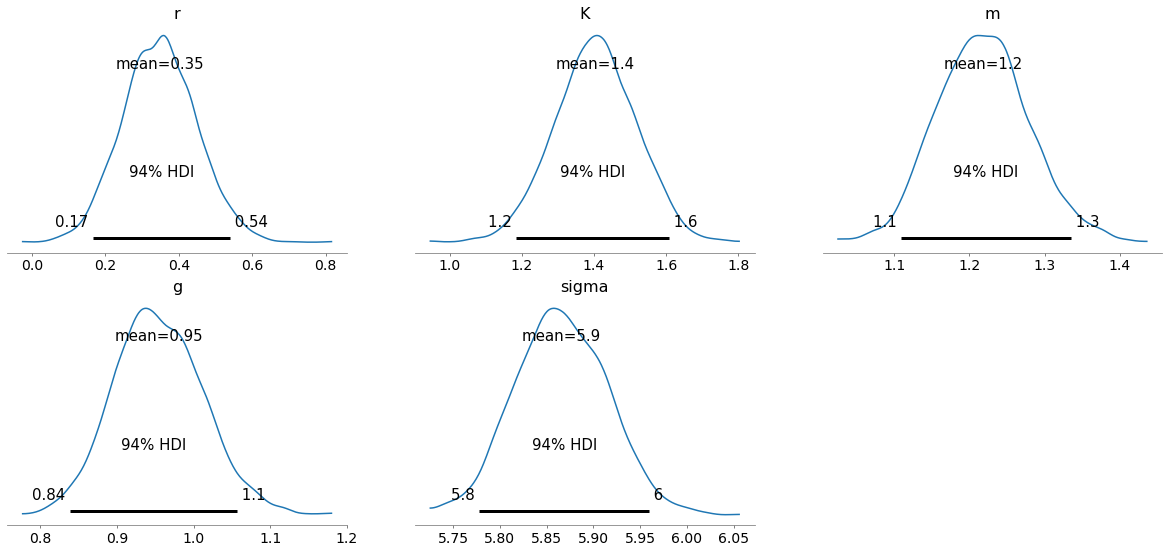

In [81]:
import arviz as az

# Convert the trace to an ArviZ InferenceData object
inference_data = az.from_pymc3(trace)

# Plot the posterior distributions
az.plot_posterior(inference_data)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


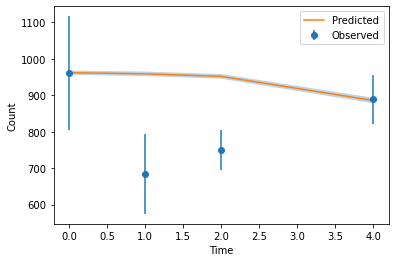

In [104]:
# Define a function that takes parameters and returns expected counts
def compute_expected_counts(params, times):
    r, K, m, g = params['r'], params['K'], params['m'], params['g']
    C0 = grouped_data['mean'].iloc[0]
    expected_counts = [odeint(logistic_decay_model, C0, [0, t], args=(r, K, m, g))[-1][0] for t in times]
    return np.array(expected_counts)

# Sample from the posterior predictive distribution
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=50)

# Compute the mean and standard deviation of the posterior predictive samples
expected_mean = np.mean(ppc['likelihood'], axis=0)
expected_std = np.std(ppc['likelihood'], axis=0)

time_values = grouped_data['Time'].values
mean_values = grouped_data['mean'].values
std_values = grouped_data['std'].values

plt.errorbar(time_values, mean_values, yerr=std_values, fmt='o', label='Observed')
# Plot expected counts
plt.plot(time_values, expected_mean, label='Predicted')
plt.fill_between(grouped_data['Time'], expected_mean - expected_std, expected_mean + expected_std, alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()


In [6]:
# filter df to incldue only Cleaining = NIL and surface == KYDEX
data = df[ (df['Time'] > -.5)]
# Grouping the data by time, surface, and cleaning type and calculating the mean and standard deviation for each group
grouped_data = (
    data.groupby(["Time", "Surface", "Cleaning"])
    .agg(mean=("Count", "mean"), std=("Count", "std"))
    .reset_index()
)

# Displaying the first few rows of the grouped data
print(grouped_data)


def extract_CON_data(data_path):
    data = pd.read_csv(data_path)
    CON_data = data[data['Cleaning'] == 'CON']
    return CON_data

CON_data = extract_CON_data(data_path)

def fit_logistic_growth_to_CON(CON_data):
    # Extract unique surfaces
    surfaces = CON_data['Surface'].unique()
    logistic_growth_params = {}

    # Fit the logistic growth model for each surface
    for surface in surfaces:
        surface_data = CON_data[CON_data['Surface'] == surface]
        times = surface_data['Time'].values
        observed_means = surface_data['mean'].values
        # Fit the logistic model (you may need to define this function or use an optimization method)
        r, K = fit_logistic_model(times, observed_means)
        logistic_growth_params[surface] = {'r': r, 'K': K}

    return logistic_growth_params

logistic_growth_params = fit_logistic_growth_to_CON(CON_data)

    Time          Surface Cleaning         mean         std
0    0.0            KYDEX      ALC  1074.000000  108.629646
1    0.0            KYDEX      CON  1179.000000   46.699036
2    0.0            KYDEX       DW   960.500000  156.469486
3    0.0  Stainless Steel      ALC   109.600000   57.808304
4    0.0  Stainless Steel      CON   295.000000   67.115572
5    0.0  Stainless Steel       DW    33.400000    5.941380
6    1.0            KYDEX      ALC   754.833333   85.630407
7    1.0            KYDEX      CON  1027.166667   44.941814
8    1.0            KYDEX       DW   683.500000  109.260697
9    1.0  Stainless Steel      ALC   102.200000   16.468151
10   1.0  Stainless Steel      CON   135.600000   43.275859
11   1.0  Stainless Steel       DW    20.800000    8.167007
12   2.0            KYDEX      ALC   785.000000  119.042849
13   2.0            KYDEX      CON  1053.166667   21.618665
14   2.0            KYDEX       DW   750.166667   54.027462
15   2.0  Stainless Steel      ALC    36

NameError: name 'data_path' is not defined

# 3.0 ABC From SCRATCH

In [7]:
# extract all values for cleaning == "NIL" or cleaning == "CON"
con_data=df[df["Cleaning"].isin(["NIL", "CON"])]
#Drop colum Cleaning
#con_data=con_data.drop(columns=["Cleaning"])

# find mean  and std of Count for each time point, grouped by Surface
#con_data = con_data.groupby(["Surface", "Time"]).agg({"Count": ["mean", "std"]}).reset_index()

con_data = (
    con_data.groupby(["Time", "Surface"])
    .agg(mean=("Count", "mean"), std=("Count", "std"))
    .reset_index()
)
con_data

,Time,Surface,mean,std
0,-48.000000,KYDEX,10052.000000,NaN
1,-48.000000,Stainless Steel,5995.750000,514.610775
2,-41.000000,KYDEX,2245.666667,263.671513
3,-41.000000,Stainless Steel,1122.750000,43.522982
4,-24.000000,KYDEX,1186.166667,224.714411
5,-24.000000,Stainless Steel,718.000000,295.193157
6,-17.000000,KYDEX,753.333333,105.555041
7,-17.000000,Stainless Steel,382.666667,160.503375
8,-0.666667,KYDEX,1223.000000,212.352537
9,-0.666667,Stainless Steel,247.666667,93.107823


In [76]:
# First estimate r and k from the CON data

import pandas as pd
from scipy.optimize import curve_fit

# Load data

# Extract CON data
#con_data = observed_data[observed_data['Cleaning'] == 'CON']

# Logistic growth model
def logistic_growth(t, C0, r, K):
    return K / (1 + ((K - C0) / C0) * np.exp(-r * t))

# Fit logistic growth model to CON data for each surface and extract r and K
fit_params = {}

surfaces = ['KYDEX', 'Stainless Steel']
for surface in surfaces:
    surface_data = con_data[con_data['Surface'] == surface]
    times = surface_data['Time'].values
    means = surface_data['mean'].values
    
    # Initial guess: C0 from the data, arbitrary r and K
    initial_guess = [means[0], 0.1, 2 * means[0]]
    
    # Fit
    params, _ = curve_fit(logistic_growth, times, means, p0=initial_guess)
    C0, r, K = params
    fit_params[surface] = {'C0': C0, 'r': r, 'K': K}

print(fit_params)


{'KYDEX': {'C0': 0.545593923608381, 'r': -0.20455899876837547, 'K': 12723834423.153332}, 'Stainless Steel': {'C0': 0.08468304373538209, 'r': -0.23263366414248537, 'K': 10180567735.662352}}


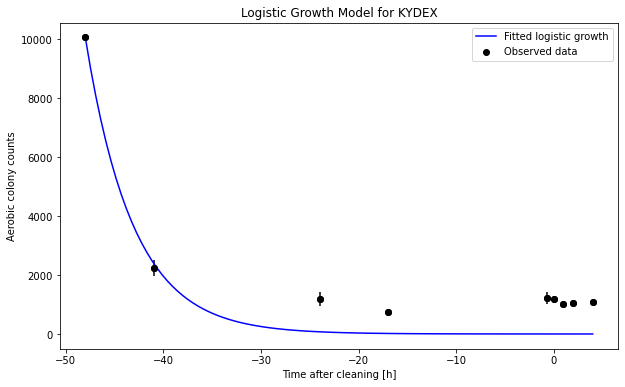

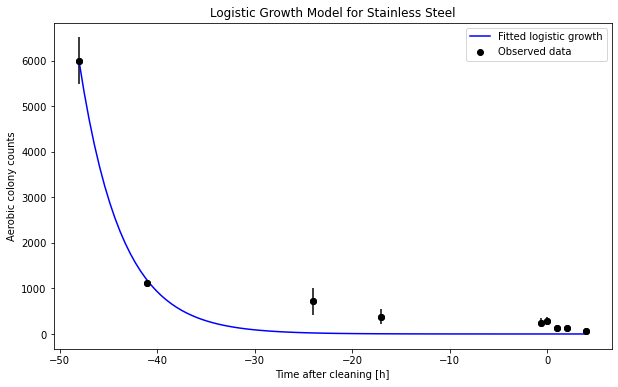

In [86]:

# Define the time values
times = np.linspace(-48, 4, 100)  # You may adjust this to match the range of your observations

# Create a plot for each surface
for surface in ['KYDEX', 'Stainless Steel']:
    plt.figure(figsize=(10, 6))
    plt.title(f'Logistic Growth Model for {surface}')
    plt.xlabel('Time after cleaning [h]')
    plt.ylabel('Aerobic colony counts')

    # Plot the observed data
    observed_surface_data = con_data[con_data['Surface'] == surface]
    plt.scatter(observed_surface_data['Time'], observed_surface_data['mean'], label='Observed data', color='black')
    plt.errorbar(observed_surface_data['Time'].values, observed_surface_data['mean'].values, yerr=observed_surface_data['std'],fmt='o', color='black')
    # Plot the fitted logistic growth curve
    C0, r, K = fit_params[surface]['C0'], fit_params[surface]['r'], fit_params[surface]['K']
    plt.plot(times, logistic_growth(times, C0, r, K), label='Fitted logistic growth', color='blue')
    
    
    plt.legend()
    plt.show()


## PREPARE DATA 

Here we copy all the NIL  cleaning values and assign them to both ALC and DW. We also assume that the standard deviation is linearly related to mean and so that we impute the STD for the first values as 1000. 

In [77]:
#Prepare data for fitting ODE model - Include ALL NIL rows for each surface and cleaning type
# Find rows with cleaning type 'NIL'
nil_rows = df[df['Cleaning'] == 'NIL'].copy()

data = df[df['Cleaning'] != 'NIL'].copy()
# Create duplicate rows for 'DW' and 'ALC' cleaning types for each surface
for surface in df['Surface'].unique():
    surface_nil_rows = nil_rows[nil_rows['Surface'] == surface].copy()
    
    # Set cleaning type to 'DW'
    surface_nil_rows['Cleaning'] = 'DW'
    data = pd.concat([data, surface_nil_rows], ignore_index=True)

    # Set cleaning type to 'ALC'
    surface_nil_rows['Cleaning'] = 'ALC'
    data = pd.concat([data, surface_nil_rows], ignore_index=True)

    # Set cleaning type to 'CON'
    surface_nil_rows['Cleaning'] = 'CON'
    data = pd.concat([data, surface_nil_rows], ignore_index=True)

# Check the updated dataframe


observed_data = (
    data.groupby(["Time", "Surface", "Cleaning"])
    .agg(mean=("Count", "mean"), std=("Count", "std"))
    .reset_index()
)
observed_data
# replace NANs wtith 1000
observed_data = observed_data.fillna(1000)

# print unique Time values in data
print(observed_data["Time"].unique())

[-48.         -41.         -24.         -17.          -0.66666667
   0.           1.           2.           4.        ]


## 3.2. Define the Model

In [6]:
def logistic_decay_model(params, times, surface, cleaning):
    surface_key = surface.replace(' ', '_')  # Replace space with underscore
    r = params[surface_key + '_r']
    K = params[surface_key + '_K']
    m = params[surface_key + '_m_' + cleaning]
    g = params[surface_key + '_g_' + cleaning]
    C0 = params[surface_key + '_C0_' + cleaning]  # Use the initial condition from the parameters

    def dCdt(C, t):
        return r * C * (1 - C / K) - m * np.exp(-g * t) * C

    C = odeint(dCdt, C0, times) #+ np.random.normal(0, 1, len(times))
    return C.flatten()

def richardson_model(params, times, surface, cleaning):
    surface_key = surface.replace(' ', '_')
    r = params[surface_key + '_r']
    alpha = params[surface_key + '_alpha_' + cleaning]
    C0 = params[surface_key + '_C0_' + cleaning]

    def dCdt(C, t):
        return r * C**alpha

    C = odeint(dCdt, C0, times) #+ np.random.normal(0, 1, len(times))
    return C.flatten()


def gompertz_model(params, times, surface, cleaning):
    surface_key = surface.replace(' ', '_')
    r = params[surface_key + '_r']
    K = params[surface_key + '_K']
    C0 = params[surface_key + '_C0_' + cleaning]

    def dCdt(C, t):
        return r * np.log(K / C) * C 

    C = odeint(dCdt, C0, times) #+ np.random.normal(0, 1, len(times))
    return C.flatten()



def quorum_sensing_model(params, times, surface, cleaning):
    # Suppressing the warning
    np.seterr(invalid='ignore')
    surface_key = surface.replace(' ', '_')  # Replace space with underscore
    r = params[surface_key + '_r']
    K = params[surface_key + '_K']
    m = params[surface_key + '_m_' + cleaning]
    g = params[surface_key + '_g_' + cleaning]
    C0 = params[surface_key + '_C0_' + cleaning]  # Use the initial condition from the parameters
    q = params[surface_key + '_q_' + cleaning]
    Cq = params[surface_key + '_Cq_' + cleaning]
    n = params[surface_key + '_n_' + cleaning]

    def dCdt(C, t):
        quorum_sensing_term = q * (C ** n) / ((C ** n) + (Cq ** n))
        return r * C * (1 - C / K) - m * np.exp(-g * t) * C + quorum_sensing_term 

    C = odeint(dCdt, C0, times)
    return C.flatten() + np.random.normal(0, 10, len(times))





## 3.3 Priors

In [31]:
def sample_from_prior():
    priors = {
        'KYDEX_q_ALC': np.random.uniform(0, 12),
        'KYDEX_q_CON': 0,#np.random.uniform(0, 200),
        'KYDEX_q_DW': np.random.uniform(0, 1),
        'KYDEX_n_ALC': np.random.uniform(0, 5),
        'KYDEX_n_CON': 0,#np.random.uniform(0, 200),
        'KYDEX_n_DW': np.random.uniform(0, 5),
        'KYDEX_Cq_ALC': np.random.uniform(0, 110),
        'KYDEX_Cq_CON': 0,#np.random.uniform(0, 200),
        'KYDEX_Cq_DW': np.random.uniform(0, 1200),
        'KYDEX_r': np.random.uniform(0, 2),
        'KYDEX_K': np.random.uniform(800, 1200),
        'KYDEX_m_ALC': np.random.uniform(0, .3),
        'KYDEX_g_ALC': np.random.uniform(0, .15),
        'KYDEX_m_CON': 0,#np.random.uniform(0, 0),
        'KYDEX_g_CON': 0,#np.random.uniform(0, 0),
        'KYDEX_m_DW': np.random.uniform(0, 2),
        'KYDEX_g_DW': np.random.uniform(0, 2),
        'KYDEX_alpha_DW': np.random.uniform(0, 2),
        'KYDEX_alpha_ALC': np.random.uniform(0, 2),
        'KYDEX_alpha_CON': np.random.uniform(0, 2),
        'Stainless_Steel_alpha_CON': 0,
        'Stainless_Steel_q_ALC': np.random.uniform(0, 1),
        'Stainless_Steel_q_CON': 0,#np.random.uniform(0, 200),
        'Stainless_Steel_q_DW': np.random.uniform(0, 1),
        'Stainless_Steel_n_ALC': np.random.uniform(0, 5),
        'Stainless_Steel_n_CON': 0,#np.random.uniform(0, 200),
        'Stainless_Steel_n_DW': np.random.uniform(0, 5),
        'Stainless_Steel_Cq_ALC': np.random.uniform(0, 1000),
        'Stainless_Steel_Cq_CON': 0,#np.random.uniform(0, 200),
        'Stainless_Steel_Cq_DW': np.random.uniform(0, 1000),
        'Stainless_Steel_r': np.random.uniform(0, 1),
        'Stainless_Steel_K': np.random.uniform(100, 350),
        'Stainless_Steel_m_ALC': np.random.uniform(0, 1),
        'Stainless_Steel_g_ALC': 0,#np.random.uniform(0, 200),
        'Stainless_Steel_m_CON': 0,#np.random.uniform(0, 0),
        'Stainless_Steel_g_CON': 0,#np.random.uniform(0, 0),
        'Stainless_Steel_m_DW': np.random.uniform(0, 2),
        'Stainless_Steel_g_DW': np.random.uniform(0, 2),
        'Stainless_Steel_alpha_DW': np.random.uniform(0, 200),
        'Stainless_Steel_alpha_ALC': np.random.uniform(0, 200),
        
    }
    # Different ranges for C0 for KYDEX and Stainless Steel
    for surface in ['KYDEX', 'Stainless_Steel']:
        for cleaning in ['ALC', 'CON', 'DW']:
            if surface == 'KYDEX':
                priors[surface + '_C0_' + cleaning] = np.random.uniform(800, 1200)
            else:
                priors[surface + '_C0_' + cleaning] = np.random.uniform(10, 200)
    
    return priors

In [8]:

def simulate_model(model_func, params, times):
    simulated_data = []
    for surface in ['KYDEX', 'Stainless Steel']:
        for cleaning in ['ALC', 'CON', 'DW']:
            mean_values = model_func(params, times, surface, cleaning)
            for time, mean in zip(times, mean_values):
                simulated_data.append((time, surface, cleaning, mean))
    return pd.DataFrame(simulated_data, columns=['Time', 'Surface', 'Cleaning', 'mean_sim'])


In [9]:
observed_data

,Time,Surface,Cleaning,mean,std
0,-48.000000,KYDEX,ALC,10052.000000,NaN
1,-48.000000,KYDEX,CON,10052.000000,NaN
2,-48.000000,KYDEX,DW,10052.000000,NaN
3,-48.000000,Stainless Steel,ALC,5995.750000,514.610775
4,-48.000000,Stainless Steel,CON,5995.750000,514.610775
5,-48.000000,Stainless Steel,DW,5995.750000,514.610775
6,-41.000000,KYDEX,ALC,2245.666667,263.671513
7,-41.000000,KYDEX,CON,2245.666667,263.671513
8,-41.000000,KYDEX,DW,2245.666667,263.671513
9,-41.000000,Stainless Steel,ALC,1122.750000,43.522982


## 3.4. Distance metric

In [32]:

def distance(simulated_data, observed_data):
    # Merge simulated and observed data on common keys (Time, Surface, Cleaning)
    merged_data = pd.merge(simulated_data, observed_data, on=['Time', 'Surface', 'Cleaning'])
    # Compute Manhattan differences
    squared_diffs = np.abs(merged_data['mean_sim'] - merged_data['mean'])
    return sum(squared_diffs)


def distance_std(simulated_data, observed_data, epsilon=1e-2):
    merged_data = pd.merge(simulated_data, observed_data.rename(columns={'mean': 'mean_obs', 'std': 'std_obs'}), on=['Time', 'Surface', 'Cleaning'])
    weighted_diffs = np.abs((merged_data['mean_sim'] - merged_data['mean_obs'])) / (merged_data['std_obs'] + epsilon)
    return sum(weighted_diffs)
    

from scipy.stats import median_abs_deviation 

def distance_pcmad(simulated_data, observed_data):
    # Merge simulated and observed data on common keys (Time, Surface, Cleaning)
    merged_data = pd.merge(simulated_data, observed_data, on=['Time', 'Surface', 'Cleaning'])
    
    # Compute the absolute deviations
    absolute_deviations = np.abs(merged_data['mean_sim'] - merged_data['mean'])

    # Compute the MAD
    mad = median_abs_deviation(absolute_deviations, scale='normal')

    # Identify severe outliers, e.g., those more than 3 MADs from the median
    severe_outliers = absolute_deviations > 3 * mad

    # Compute the MADO
    mado = median_abs_deviation(absolute_deviations - merged_data['mean'], scale='normal')

    # Compute the PCMAD
    if np.sum(severe_outliers) / len(absolute_deviations) <= 1/3:
        scale = mad
    else:
        scale = mad + mado

    # Compute the scaled absolute differences
    scaled_diffs = absolute_deviations / scale

    return np.sum(scaled_diffs)


# 5. Run

In [6]:
from tqdm import tqdm

In [161]:
# serial implementation
def abc(observed_data, times, num_samples, epsilon, models, distance_func):
    all_accepted_params = {}
    all_accepted_distances= {}
    for model_name, model_func in models.items():
        print(f"Fitting model: {model_name}")
        accepted_params = []
        accepted_distances = []
        i = 0

        # Creating a progress bar using tqdm
        with tqdm(total=num_samples, desc="Sampling", ncols=100) as pbar:
            while len(accepted_params) < num_samples:
                params = sample_from_prior()
                simulated_data = simulate_model(model_func, params, times)
                dist = distance_manhattan(simulated_data, observed_data)
                if  dist < epsilon:
                    accepted_params.append(params)
                    accepted_distances.append(dist)
                    pbar.update(1)  # Updating the progress bar by 1 for each accepted sample

        all_accepted_params[model_name] = accepted_params
        all_accepted_distances[model_name] = accepted_distances
    return all_accepted_params, all_accepted_distances


# Define the models to fit

models = {
    'Logistic Decay': logistic_decay_model,
    #'Richardson': richardson_model,
    #'Gompertz': gompertz_model,
    #'Quorum Sensing': quorum_sensing_model  # Add the new model
}

times = np.array([0,1,2,4])#observed_data['Time'].unique()
epsilon = 50000
num_samples = 100

from abc_cleaning import logistic_decay_model, richardson_model, gompertz_model, quorum_sensing_model, sample_from_prior, simulate_model, distance_pcmad, single_simulation
from abc_cleaning import quorum_sensing_autoinducer_model, distance_manhattan, distance_std
import numpy as np


accepted_params = abc(observed_data, times, num_samples, epsilon, models,distance_func=distance_manhattan)


Fitting model: Logistic Decay


Sampling:   0%|                                                             | 0/100 [00:00<?, ?it/s]/Users/marcofking/Documents/GitHub/Cleaning/Code/ANNABELCODE/abc_cleaning.py:276: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  'KYDEX_g_ALC': np.random.uniform(20, 25),
/Users/marcofking/Documents/GitHub/Cleaning/Code/ANNABELCODE/abc_cleaning.py:276: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  'KYDEX_g_ALC': np.random.uniform(20, 25),
/Users/marcofking/Documents/GitHub/Cleaning/Code/ANNABELCODE/abc_cleaning.py:276: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  'KYDEX_g_ALC': np.random.uniform(20, 25),
/Users/marcofking/Documents/GitHub/Cleaning/Code/ANNABELCODE/abc_cleaning.py:276: UserWarning: You are merging on int and float columns where the float values are

In [ ]:
## Parallel version

In [155]:
## Parallel version
from concurrent.futures import ProcessPoolExecutor, as_completed

from abc_cleaning import logistic_decay_model, richardson_model, gompertz_model, quorum_sensing_model, sample_from_prior, simulate_model, distance_pcmad, single_simulation
from abc_cleaning import quorum_sensing_autoinducer_model, distance_manhattan, distance_std
import numpy as np


def abc(observed_data, times, num_samples, epsilon, models, distance_func):
    all_accepted_params = {}
    all_accepted_distances = {}  # A dictionary to store accepted distances for each model
    
    for model_name, model_func in models.items():
        print(f"Fitting model: {model_name}")
        accepted_params = []
        accepted_distances = []  # List to store accepted distances for the current model

        with tqdm(total=num_samples, desc="Sampling", ncols=100) as pbar:
            with ProcessPoolExecutor(max_workers=1) as executor:
                futures = [executor.submit(single_simulation, model_func, times, epsilon, observed_data, distance_func) for _ in range(num_samples)]
                while len(accepted_params) < num_samples:
                    for future in as_completed(futures):
                        result = future.result()
                        if result is not None:
                            params, dist = result  # Modify to unpack parameters and distance
                            accepted_params.append(params)
                            accepted_distances.append(dist)  # Save the accepted distance
                            pbar.update(1)
                            if len(accepted_params) == num_samples:
                                break
                        if len(accepted_params) + len(futures) < num_samples:
                            futures.append(executor.submit(single_simulation, model_func, times, epsilon, observed_data, distance_func))
                
        all_accepted_params[model_name] = accepted_params
        all_accepted_distances[model_name] = accepted_distances  # Save accepted distances for the current model
    
    return all_accepted_params, all_accepted_distances  # Return both parameters and distances


 
# Define the models to fit
models = {
    'Logistic Decay': logistic_decay_model,
    #'Richardson': richardson_model,
    #'Gompertz': gompertz_model,
    #'Quorum Sensing': quorum_sensing_model,
    #'Quorum Sensing with Autoinducer': quorum_sensing_autoinducer_model  # Add the new model
}

times = np.array([0,1,2,4]) #observed_data['Time'].unique()
epsilon = 70,000
num_samples = 1000


#with stdout_redirected():
accepted_params, accepted_distances = abc(observed_data, times, num_samples, epsilon, models,distance_func=distance_manhattan)


Fitting model: Logistic Decay


Sampling:   0%|                                                            | 0/1000 [00:03<?, ?it/s]


TypeError: '<' not supported between instances of 'float' and 'tuple'

## 6. Plots

## 6.0 Simluation ODES vs Experimental data over time

In [162]:

def plot_best_predictions(model_func, accepted_params, observed_data, times, surfaces, cleaning_methods, ax_title_prefix=''):
    # List to store distances
    distances = []
    # Simulate the model for each set of accepted parameters and compute distances
    for params in accepted_params:
        simulated_data = simulate_model(model_func, params, times)
        dist = distance_manhattan(simulated_data, observed_data)  # Ensure that the distance function also uses 'mean_sim'
        distances.append((params, dist))

    # Sort by distance and select the best 10
    best_params = [item[0] for item in sorted(distances, key=lambda x: x[1])[:4]]

    # Create a figure to hold the subplots
    fig, axes = plt.subplots(len(surfaces), len(cleaning_methods), figsize=(15, 10), sharex=False, sharey=False)

    # Define colors for different cleaning methods
    cleaning_colors = {'ALC': 'blue', 'CON': 'green', 'DW': 'red'}

    # Iterate through the surfaces and cleaning methods, and plot the corresponding data
    for i, surface in enumerate(surfaces):
        for j, cleaning in enumerate(cleaning_methods):
            ax = axes[i, j]

            # Plot predictions for the best parameters
            for params in best_params:
                simulated_data = simulate_model(model_func, params, times)
                surface_sim_data = simulated_data[(simulated_data['Surface'] == surface) & (simulated_data['Cleaning'] == cleaning)]
                ax.plot(surface_sim_data['Time'].values, surface_sim_data['mean_sim'].values, color=cleaning_colors[cleaning], alpha=0.8)  # Use 'mean_sim' here

            # Plot experimental data
            surface_obs_data = observed_data[(observed_data['Surface'] == surface) & (observed_data['Cleaning'] == cleaning)]
            ax.errorbar(surface_obs_data['Time'].values, surface_obs_data['mean'].values, yerr=surface_obs_data['std'].values, fmt='o', color='black')

            # Set titles and labels
            ax.set_title(f'{ax_title_prefix} {surface} - {cleaning}')
            if i == len(surfaces) - 1:
                ax.set_xlabel('Time after cleaning [h]')
            if j == 0:
                ax.set_ylabel('Aerobic colony counts')
            # Adjusting axis limits for each surface (optional)
            if surface == 'Stainless Steel':
                ax.set_ylim([0, 8000])
            elif surface == 'KYDEX':
                ax.set_ylim([400, 14000])
        

    plt.tight_layout()
    plt.show()
    return distances

# Usage
surfaces = ['Stainless Steel', 'KYDEX']
cleaning_methods = ['ALC','DW'] #,'CON'
times = np.linspace(0, 4, 100)
## Dictionary to store distances for each model
model_distances = {}
for model_name, model_func in models.items():
    distances = plot_best_predictions(model_func, accepted_params[model_name], observed_data, times, surfaces, cleaning_methods, ax_title_prefix=model_name)
    model_distances[model_name] = [dist for _, dist in distances]


TypeError: tuple indices must be integers or slices, not str

### Plot of distances

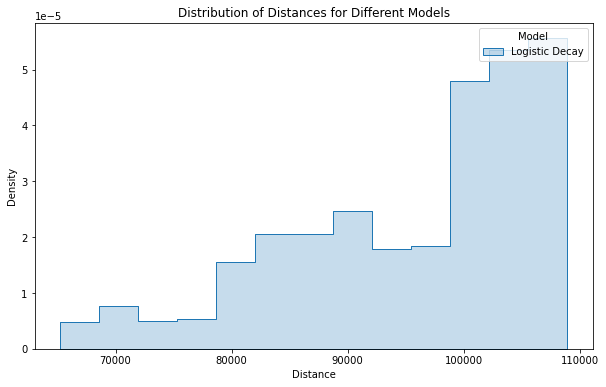

            Distance
count    1000.000000
mean    95573.055294
std     10740.206214
min     65208.327196
25%     86957.817362
50%     99695.848072
75%    104022.876110
max    108908.460374


In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the dictionary of accepted distances into a DataFrame
distances_list = []
for model_name, distances in accepted_distances.items():
    for dist in distances:
        distances_list.append({'Model': model_name, 'Distance': dist})
        
distances_df = pd.DataFrame(distances_list)

# Plot the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=distances_df, x='Distance', hue='Model', element="step", stat="density", common_norm=False)
plt.title('Distribution of Distances for Different Models')
plt.ylabel('Density')
plt.xlabel('Distance')
plt.show()

# Display summary statistics
print(distances_df.describe())


In [144]:
# convert parameters to dataframe and save as csv 
accepted_params_df = pd.DataFrame(accepted_params)
accepted_params_df.to_csv( "../../Annabel_outputs/accepted_params_logistic_decay.csv", index=False)

## 6.1 Parameter Marginal distributions

In [164]:


def plot_marginal_distributions(accepted_params, model_name):
    # Extracting values for each parameter
    params_values = {key: [] for key in expected_keys}
    
    for param_set in accepted_params[model_name]:
        for key in expected_keys:
            params_values[key].append(param_set[key])
            
    # Plotting
    n = len(expected_keys)
    rows = int(n / 5) + (1 if n % 5 != 0 else 0)
    fig, axs = plt.subplots(rows, 5, figsize=(15, 5*rows))
    
    # Ensure axs is a 2D array for consistent indexing
    if rows == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i, key in enumerate(expected_keys):
        row, col = divmod(i, 5)
        ax = axs[row, col]
        ax.hist(params_values[key], bins=50, edgecolor='k', alpha=0.7)
        ax.set_title(f'{key}')
        ax.set_xlabel(key)
        ax.set_ylabel('Frequency')
    
    # Remove any unused subplots
    for j in range(i+1, 4*rows):
        row, col = divmod(j, 4)
        fig.delaxes(axs[row, col])
    
    plt.tight_layout()
    plt.show()

# Using the function
model_name = 'Logistic Decay'
plot_marginal_distributions(accepted_params, model_name)


TypeError: tuple indices must be integers or slices, not str

In [165]:
# Joint plots of accepted parameters for each model

from pandas import json_normalize

# Iterate through the models and their accepted parameters
for model_name, params_list in accepted_params.items():
    # Flatten the list of dictionaries into a DataFrame
    accepted_params_df = json_normalize(params_list)

    print(f"Plots for {model_name}")
    
    # Iterate through surface types and cleaning types
    for surface in ['KYDEX']: # 'Stainless Steel'
        for cleaning in ['ALC']:
            # Filter the DataFrame to include only the relevant columns
            cols_to_include = [col for col in accepted_params_df.columns if surface in col and cleaning in col]
            filtered_df = accepted_params_df[cols_to_include]

            # Iterate through all combinations of two parameters
            for i in range(len(cols_to_include)):
                for j in range(i + 1, len(cols_to_include)):
                    param1 = filtered_df.columns[i]
                    param2 = filtered_df.columns[j]
                    sns.jointplot(x=filtered_df[param1], y=filtered_df[param2], kind="hex", color="#4CB391",bins="log", gridsize=30)
                    plt.title(f"{model_name} - {surface} - {cleaning}")
                    plt.show()


AttributeError: 'tuple' object has no attribute 'items'

## 7.0 Quick Test

In [28]:
synthetic_params = {
    'KYDEX_r': 0.5,
    'KYDEX_K': 1000,
    'KYDEX_m_ALC': 0.2,
    'KYDEX_g_ALC': 0.1,
    'KYDEX_C0_ALC': 1074,
    'KYDEX_q_ALC': 10,
    'KYDEX_Cq_ALC': 100,
    'KYDEX_n_ALC': 2,
    'KYDEX_m_CON': 0.15,
    'KYDEX_g_CON': 0.05,
    'KYDEX_C0_CON': 1179,
    'KYDEX_q_CON': 8,
    'KYDEX_Cq_CON': 90,
    'KYDEX_n_CON': 2,
    'KYDEX_m_DW': 0.1,
    'KYDEX_g_DW': 0.05,
    'KYDEX_C0_DW': 960.5,
    'KYDEX_q_DW': 6,
    'KYDEX_Cq_DW': 80,
    'KYDEX_n_DW': 2,
    'Stainless_Steel_r': 0.3,
    'Stainless_Steel_K': 300,
    'Stainless_Steel_m_ALC': 0.15,
    'Stainless_Steel_g_ALC': 0.05,
    'Stainless_Steel_C0_ALC': 109.6,
    'Stainless_Steel_q_ALC': 5,
    'Stainless_Steel_Cq_ALC': 70,
    'Stainless_Steel_n_ALC': 2,
    'Stainless_Steel_m_CON': 0.12,
    'Stainless_Steel_g_CON': 0.04,
    'Stainless_Steel_C0_CON': 295,
    'Stainless_Steel_q_CON': 4,
    'Stainless_Steel_Cq_CON': 60,
    'Stainless_Steel_n_CON': 2,
    'Stainless_Steel_m_DW': 0.08,
    'Stainless_Steel_g_DW': 0.03,
    'Stainless_Steel_C0_DW': 33.4,
    'Stainless_Steel_q_DW': 3,
    'Stainless_Steel_Cq_DW': 50,
    'Stainless_Steel_n_DW': 2,
}

# Times at which to evaluate the model
times = np.linspace(0, 4, 400)

# Simulating the synthetic data
synthetic_data = simulate_model(quorum_sensing_model, synthetic_params, times)
synthetic_data.head()

# Modify the simulate_model function to only simulate data for the "KYDEX" surface
def simulate_model1(model_func, params, times):
    simulated_data = []
    for cleaning in ['ALC', 'CON']:
        mean_values = model_func(params, times, 'KYDEX', cleaning)
        for time, mean in zip(times, mean_values):
            simulated_data.append((time, 'KYDEX', cleaning, mean))
    return pd.DataFrame(simulated_data, columns=['Time', 'Surface', 'Cleaning', 'mean_sim'])

# Generate synthetic data using the quorum sensing model
simulated_data = simulate_model1(quorum_sensing_model, synthetic_params, times)
simulated_data["mean_sim"] += np.random.normal(0, 20, len(simulated_data))  # Adding some random noise

# Filter the observed data to match the "KYDEX" surface
filtered_observed_data = observed_data[observed_data['Surface'] == 'KYDEX']

# Evaluate the distance using the distance_pcmad function
distance_value = distance_pcmad(simulated_data, filtered_observed_data)
distance_value

21.016189335483688

In [210]:
simulated_data

,Time,Surface,Cleaning,mean_sim
0,0.000000,KYDEX,ALC,1099.376494
1,0.010025,KYDEX,ALC,1085.760256
2,0.020050,KYDEX,ALC,1091.359606
3,0.030075,KYDEX,ALC,1103.216524
4,0.040100,KYDEX,ALC,1106.108059
...,...,...,...,...
795,3.959900,KYDEX,CON,859.276345
796,3.969925,KYDEX,CON,863.994511
797,3.979950,KYDEX,CON,845.205627
798,3.989975,KYDEX,CON,843.094251


In [24]:
import matplotlib.pyplot as plt

def plot_simulated_vs_observed(simulated_data, observed_data):
    surfaces = observed_data['Surface'].unique()
    cleaning_methods = observed_data['Cleaning'].unique()

    # Create a figure to hold the subplots
    fig, axes = plt.subplots(len(surfaces), len(cleaning_methods), figsize=(15, 10), sharex=True, sharey=True)

    # Iterate through the surfaces and cleaning methods, and plot the corresponding data
    for i, surface in enumerate(surfaces):
        for j, cleaning in enumerate(cleaning_methods):
            ax = axes[i, j]

            # Plot simulated data
            surface_sim_data = simulated_data[(simulated_data['Surface'] == surface) & (simulated_data['Cleaning'] == cleaning)]
            ax.plot(surface_sim_data['Time'].values, surface_sim_data['mean_sim'].values, label='Simulated', color='blue')

            # Plot observed data
            surface_obs_data = observed_data[(observed_data['Surface'] == surface) & (observed_data['Cleaning'] == cleaning)]
            ax.errorbar(surface_obs_data['Time'].values, surface_obs_data['mean'].values, yerr=surface_obs_data['std'].values, fmt='o', label='Observed', color='red')

            # Set titles and labels
            ax.set_title(f'{surface} - {cleaning}')
            if i == len(surfaces) - 1:
                ax.set_xlabel('Time after cleaning [h]')
            if j == 0:
                ax.set_ylabel('Aerobic colony counts')

            ax.legend()

    plt.tight_layout()
    plt.show()

# Call the function with simulated and observed data
plot_simulated_vs_observed(simulated_data, observed_data)


NameError: name 'simulated_data' is not defined